In [1]:
# Main Assignment_2_NYC taxi trip duration prediction
# By Rajkumar Mouttou

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [7]:
data = pd.read_csv('dataset/02_nyc_taxi_trip_duration.csv')

In [8]:
data.head(4)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141


In [5]:
data.shape

(729322, 11)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


In [11]:
# Check if the dataset is balanced?
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,7.293220e+05
mean,1.535403,1.662055,-73.973513,40.750919,-73.973422,40.751775,9.522291e+02
std,0.498745,1.312446,0.069754,0.033594,0.069588,0.036037,3.864626e+03
min,1.000000,0.000000,-121.933342,34.712234,-121.933304,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991859,40.737335,-73.991318,40.735931,3.970000e+02
50%,2.000000,1.000000,-73.981758,40.754070,-73.979759,40.754509,6.630000e+02
75%,2.000000,2.000000,-73.967361,40.768314,-73.963036,40.769741,1.075000e+03
max,2.000000,9.000000,-65.897385,51.881084,-65.897385,43.921028,1.939736e+06


In [13]:
#Check count of unique id's in the dataset
print("There are %d unique id's in Training dataset, which is equal to the number of records"%(data.id.nunique()))

There are 729322 unique id's in Training dataset, which is equal to the number of records


In [17]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [16]:
#Convert timestamp to datetime format to fetch the other details as listed below
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [21]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
data['weekday'] = data.pickup_datetime.dt.day_name()
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

In [22]:
data.head(4)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hour
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,Monday,2,0,16
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,Friday,3,4,23
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,Sunday,2,6,17
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,Tuesday,1,1,9


In [23]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [24]:
#Calculate distance and assign new column to the dataframe.
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)

In [25]:
#Calculate Speed in km/h for further insights
data['speed'] = (data.distance/(data.trip_duration/3600))

In [26]:
#Check the type of each variable
data.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [27]:
#Dummify all the categorical features like "store_and_fwd_flag, vendor_id, month, weekday_num, pickup_hour, passenger_count" except the label i.e. "trip_duration"

dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

In [28]:
data.head(4)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_9
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,...,0,0,1,0,0,0,0,0,0,0
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,...,0,1,0,1,0,0,0,0,0,0
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,...,0,0,0,1,0,0,0,0,0,0
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,...,0,0,0,0,0,0,0,1,0,0


In [30]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'weekday', 'month', 'weekday_num', 'pickup_hour',
       'distance', 'speed', 'flag_Y', 'vendor_id_2', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'weekday_num_1', 'weekday_num_2',
       'weekday_num_3', 'weekday_num_4', 'weekday_num_5', 'weekday_num_6',
       'pickup_hour_1', 'pickup_hour_2', 'pickup_hour_3', 'pickup_hour_4',
       'pickup_hour_5', 'pickup_hour_6', 'pickup_hour_7', 'pickup_hour_8',
       'pickup_hour_9', 'pickup_hour_10', 'pickup_hour_11', 'pickup_hour_12',
       'pickup_hour_13', 'pickup_hour_14', 'pickup_hour_15', 'pickup_hour_16',
       'pickup_hour_17', 'pickup_hour_18', 'pickup_hour_19', 'pickup_hour_20',
       'pickup_hour_21', 'pickup_hour_22', 'pickup_hour_23',
       'passenger_count_1', 'passenger_count_2', 'passe

In [31]:
#Univariate Analysis
pd.options.display.float_format = '{:.2f}'.format #To suppres scientific notation.
data.passenger_count.value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
0        33
7         1
9         1
Name: passenger_count, dtype: int64

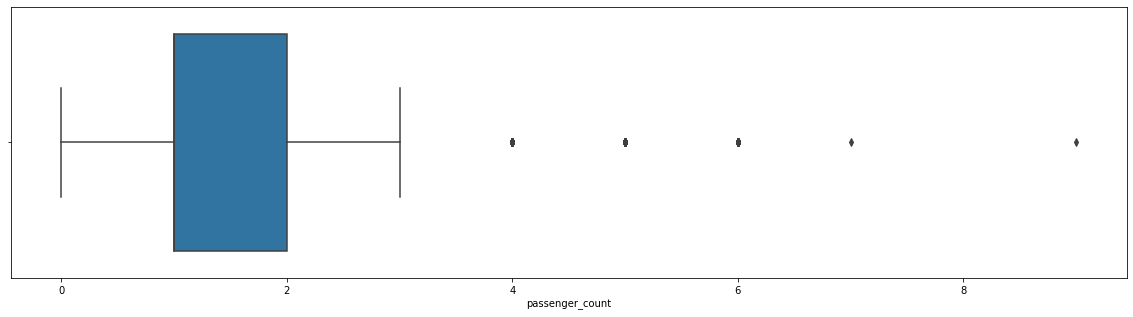

In [32]:

plt.figure(figsize = (20,5))
sns.boxplot(data.passenger_count)
plt.show()

In [33]:
# 33 observation says - 0 Passengers.
#Passenger count is a driver entered value. Since the trip is not possible without passengers. 
#It is evident that the driver forgot to enter the value for the trips with 0 passenger count. 
#Lets analyze the passenger count distribution further to make it consistent for further analysis

data['passenger_count'] = data.passenger_count.map(lambda x: 1 if x == 0 else x)

In [34]:
data = data[data.passenger_count <= 6]

In [35]:
data.passenger_count.value_counts()

1    517448
2    105097
5     38926
3     29692
6     24107
4     14050
Name: passenger_count, dtype: int64

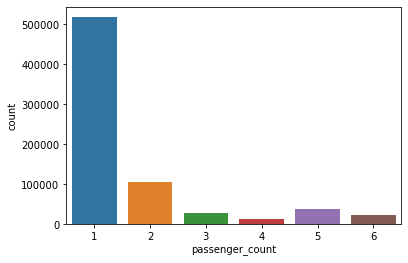

In [36]:
sns.countplot(data.passenger_count)
plt.show()

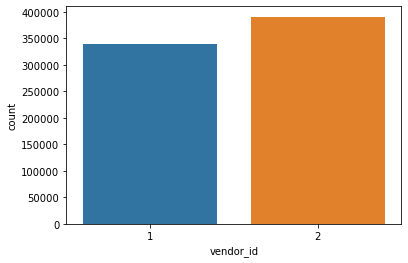

In [37]:
# Vendor
sns.countplot(data.vendor_id)
plt.show()

In [38]:
# Distance
print(data.distance.describe())

count   729320.00
mean         3.44
std          4.35
min          0.00
25%          1.23
50%          2.10
75%          3.88
max       1240.91
Name: distance, dtype: float64


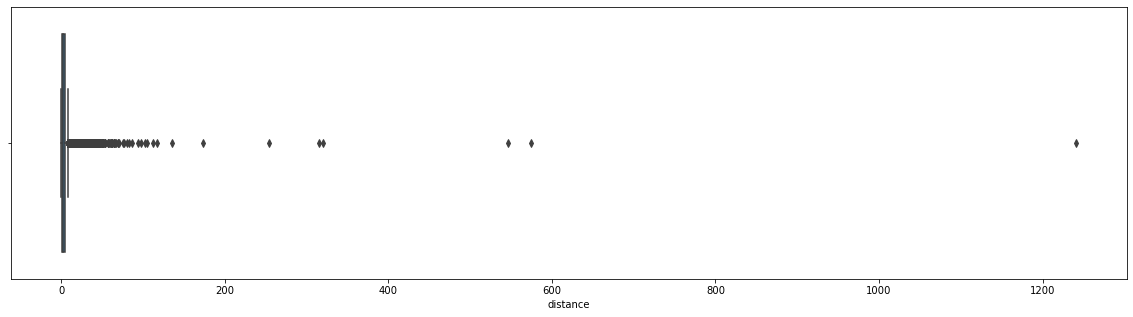

In [39]:
plt.figure(figsize = (20,5))
sns.boxplot(data.distance)
plt.show()

In [40]:
print("There are {} trip records with 0 km distance".format(data.distance[data.distance == 0 ].count()))
data[data.distance == 0 ].head()

There are 2900 trip records with 0 km distance


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_9
263,id3155891,2,2016-06-28 11:21:00,2016-06-28 11:25:00,2,-74.00,40.30,-74.00,40.30,N,...,0,0,0,1,0,0,0,0,0,0
327,id0786923,2,2016-03-26 13:34:38,2016-03-26 13:37:17,1,-74.00,40.75,-74.00,40.75,N,...,0,0,1,0,0,0,0,0,0,0
795,id2323213,2,2016-06-13 16:49:52,2016-06-13 17:04:49,5,-73.97,40.76,-73.97,40.76,N,...,0,0,0,0,0,0,1,0,0,0
1176,id3235868,1,2016-02-29 21:39:52,2016-02-29 21:44:08,1,-74.00,40.74,-74.00,40.74,N,...,0,0,1,0,0,0,0,0,0,0
1257,id1865738,2,2016-03-13 11:38:36,2016-03-13 12:00:46,2,-73.91,40.80,-73.91,40.80,N,...,0,0,0,1,0,0,0,0,0,0


In [41]:
data.trip_duration.describe()

count    729320.00
mean        952.23
std        3864.63
min           1.00
25%         397.00
50%         663.00
75%        1075.00
max     1939736.00
Name: trip_duration, dtype: float64

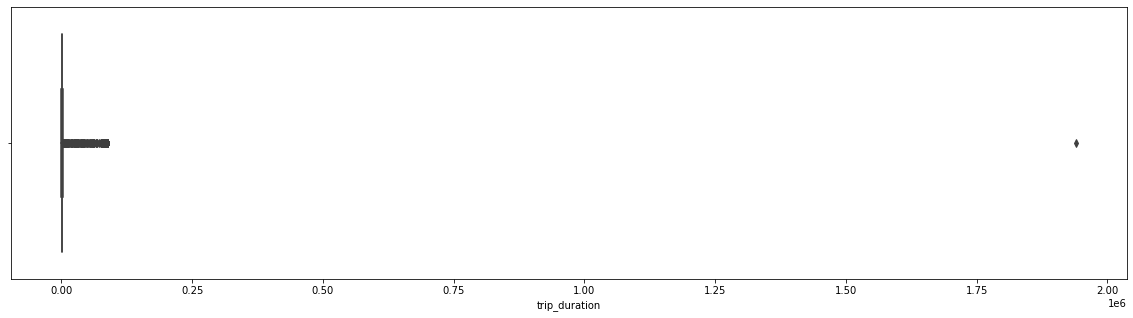

In [42]:
plt.figure(figsize = (20,5))
sns.boxplot(data.trip_duration)
plt.show()

In [43]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,max(data.trip_duration),3600))).count()

trip_duration
(1, 3601]             723251
(3601, 7201]            4964
(7201, 10801]             61
(10801, 14401]            15
(14401, 18001]             2
                       ...  
(1918801, 1922401]         0
(1922401, 1926001]         0
(1926001, 1929601]         0
(1929601, 1933201]         0
(1933201, 1936801]         0
Name: trip_duration, Length: 538, dtype: int64

In [44]:
#There are some trips with more than 24 hours of travel duration i.e. 86400 seconds. Which might have occured on weekends for the outstation travels.
#Major chunk of trips are completed within an interval of 1 hour with some good numbers of trips duration going above 1 hour.


data[data.trip_duration > 86400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_9
21813,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.79,40.64,-73.96,40.77,N,...,0,0,1,0,0,0,0,0,0,0


In [46]:
data = data[data.trip_duration <= 86400]

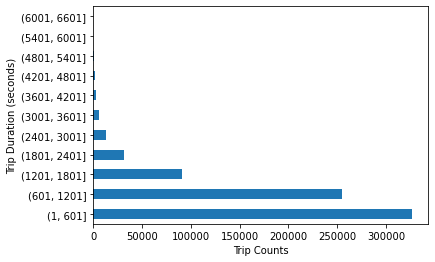

In [47]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

In [48]:
# Speed
data.speed.describe()

count   729319.00
mean        14.42
std         12.34
min          0.00
25%          9.12
50%         12.80
75%         17.84
max       5640.50
Name: speed, dtype: float64

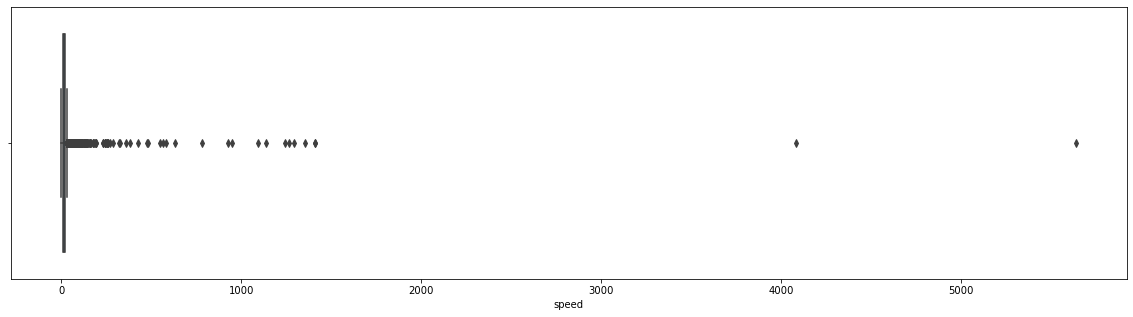

In [49]:
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

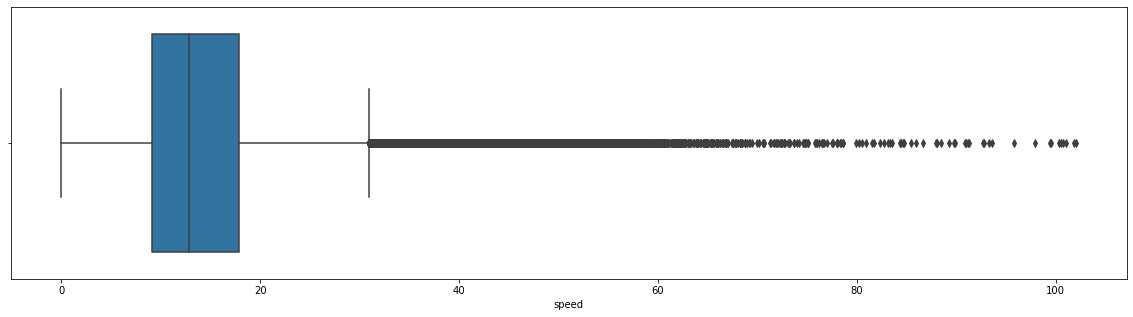

In [50]:
data = data[data.speed <= 104]
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

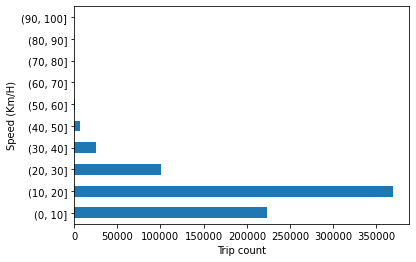

In [51]:
data.speed.groupby(pd.cut(data.speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

In [52]:
# Store_and_fwd_flag

data.flag_Y.value_counts(normalize=True)

0   0.99
1   0.01
Name: flag_Y, dtype: float64

In [53]:
data.flag_Y.value_counts()

0    725200
1      4039
Name: flag_Y, dtype: int64

In [54]:
data.vendor_id[data.flag_Y == 1].value_counts()

1    4039
Name: vendor_id, dtype: int64

In [55]:
data[data.flag_Y == 1]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_9
378,id1347533,1,2016-05-27 18:09:01,2016-05-27 18:16:30,1,-73.98,40.74,-73.98,40.72,Y,...,0,0,1,0,0,0,0,0,0,0
400,id2733049,1,2016-03-02 20:05:12,2016-03-02 20:52:52,2,-73.98,40.76,-74.00,40.61,Y,...,0,0,0,1,0,0,0,0,0,0
501,id2484490,1,2016-01-21 08:07:13,2016-01-21 08:18:21,1,-74.00,40.74,-73.98,40.76,Y,...,0,0,1,0,0,0,0,0,0,0
644,id2090829,1,2016-01-11 12:10:13,2016-01-11 12:25:41,2,-74.01,40.71,-73.98,40.75,Y,...,0,0,0,1,0,0,0,0,0,0
1278,id0512889,1,2016-06-10 21:20:14,2016-06-10 21:26:51,1,-73.96,40.77,-73.96,40.78,Y,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728481,id0008273,1,2016-04-08 17:52:56,2016-04-08 18:35:36,1,-73.97,40.76,-73.86,40.77,Y,...,0,0,1,0,0,0,0,0,0,0
728607,id3254730,1,2016-06-03 01:21:11,2016-06-03 01:30:16,1,-74.00,40.75,-74.00,40.74,Y,...,0,0,1,0,0,0,0,0,0,0
729074,id1347803,1,2016-03-17 01:24:10,2016-03-17 01:35:25,1,-73.99,40.72,-74.00,40.70,Y,...,0,0,1,0,0,0,0,0,0,0
729119,id2265972,1,2016-01-07 07:51:18,2016-01-07 07:51:41,3,-73.78,40.64,-73.78,40.64,Y,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Observations:
# Some trips are local some cover longer distance
# Almost each day is listed against offline trips.
# Offline trips were taken almost at all hours as per the search result.
# There is no month which appears to be more dominant in the results.
# Even the trip duration covers different scales.
# So all in all there doesn't seems to be any relation with either of the metric for the offline trips. Let's move ahead

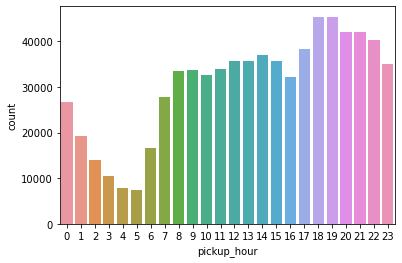

In [56]:
sns.countplot(data.pickup_hour)
plt.show()

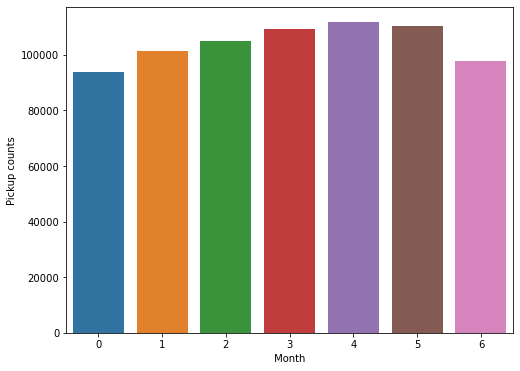

In [57]:
plt.figure(figsize = (8,6))
sns.countplot(data.weekday_num)
plt.xlabel(' Month ')
plt.ylabel('Pickup counts')
plt.show()

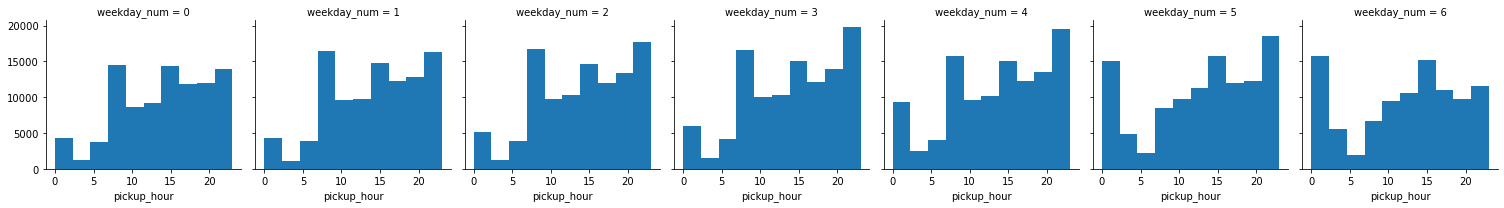

In [58]:
n = sns.FacetGrid(data, col='weekday_num')
n.map(plt.hist, 'pickup_hour')
plt.show()

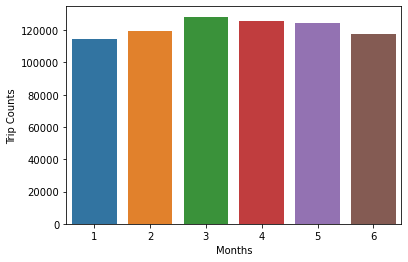

In [59]:
sns.countplot(data.month)
plt.ylabel('Trip Counts')
plt.xlabel('Months')
plt.show()

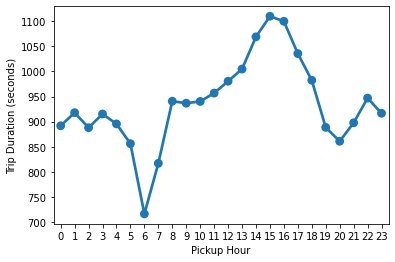

In [60]:
# Trip Duration per hour
group1 = data.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

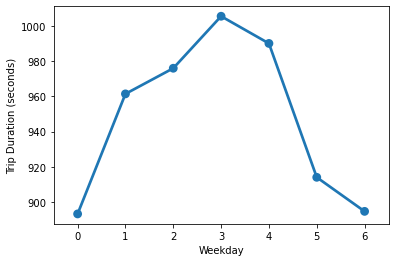

In [61]:
#Trip duration per weekday

group2 = data.groupby('weekday_num').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

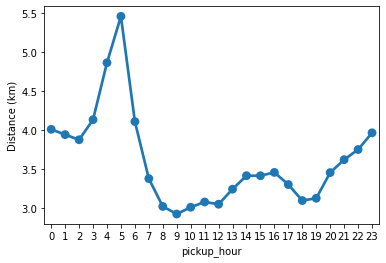

In [62]:
# Distane per hour

group5 = data.groupby('pickup_hour').distance.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Distance (km)')
plt.show()

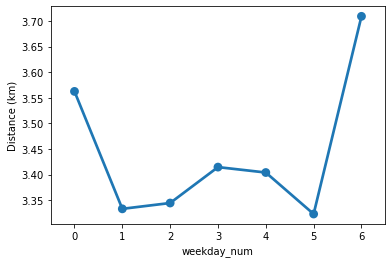

In [63]:
# Distance per week day

group6 = data.groupby('weekday_num').distance.mean()
sns.pointplot(group6.index, group6.values)
plt.ylabel('Distance (km)')
plt.show()

In [64]:
data = data[~((data.distance == 0) & (data.trip_duration >= 60))]

In [65]:
duo = data.loc[(data['distance'] <= 1) & (data['trip_duration'] >= 3600),['distance','trip_duration']].reset_index(drop=True)

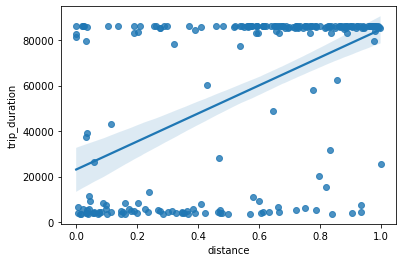

In [66]:
sns.regplot(duo.distance, duo.trip_duration)
plt.show()

In [67]:

def map_marker(set):
    # Import package for map
    from mpl_toolkits.basemap import Basemap
    plt.figure(figsize = (20,20))

    # Set the limits of the map to the minimum and maximum coordinates
    lat_min = data["pickup_latitude"].min() - .2
    lat_max = data["pickup_latitude"].max() + .2
    lon_min = data["pickup_longitude"].min() - .2
    lon_max = data["pickup_longitude"].max() + .2

    # Set the center of the map
    cent_lat = (lat_min + lat_max) / 2
    cent_lon = (lon_min + lon_max) / 2

    #Create the Basemap object with required params.
    map = Basemap(llcrnrlon=lon_min,
                  llcrnrlat=lat_min,
                  urcrnrlon=lon_max,
                  urcrnrlat=lat_max,
                  resolution='l',
                  projection='tmerc',
                  lat_0 = cent_lat,
                  lon_0 = cent_lon)

    #Style the map
    map.drawmapboundary()
    map.drawcoastlines()
    map.fillcontinents()
    map.drawcountries(linewidth=2)
    map.drawstates()


    #Fetch the long and lat in form of array
    long = np.array(data["pickup_longitude"])
    lat = np.array(data["pickup_latitude"])

    x, y = map(long, lat)
    map.plot(x, y,'ro', markersize=2, alpha=1)

    plt.show()

In [71]:
#First chech the index of the features and label
list(zip( range(0,len(data.columns)),data.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration'),
 (11, 'weekday'),
 (12, 'month'),
 (13, 'weekday_num'),
 (14, 'pickup_hour'),
 (15, 'distance'),
 (16, 'speed'),
 (17, 'flag_Y'),
 (18, 'vendor_id_2'),
 (19, 'month_2'),
 (20, 'month_3'),
 (21, 'month_4'),
 (22, 'month_5'),
 (23, 'month_6'),
 (24, 'weekday_num_1'),
 (25, 'weekday_num_2'),
 (26, 'weekday_num_3'),
 (27, 'weekday_num_4'),
 (28, 'weekday_num_5'),
 (29, 'weekday_num_6'),
 (30, 'pickup_hour_1'),
 (31, 'pickup_hour_2'),
 (32, 'pickup_hour_3'),
 (33, 'pickup_hour_4'),
 (34, 'pickup_hour_5'),
 (35, 'pickup_hour_6'),
 (36, 'pickup_hour_7'),
 (37, 'pickup_hour_8'),
 (38, 'pickup_hour_9'),
 (39, 'pickup_hour_10'),
 (40, 'pickup_hour_11'),
 (41, 'pickup_hour_12'),
 (42, 'pickup_hour_13'),
 (43, 'pickup_hour_14'),
 (44, 'pic

In [72]:
Y = data.iloc[:,10].values
X = data.iloc[:,range(15,61)].values

In [73]:
print("Let's append {} rows of 1's as the first column in the X array".format(X.shape[0]))

Let's append 727149 rows of 1's as the first column in the X array


In [74]:
X1 = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)

In [75]:
X1.shape

(727149, 47)

In [77]:

#Split raw data
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size=0.2)

#Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,Y, random_state=4, test_size=0.2)

In [78]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X,Y, random_state=4, test_size=0.2)

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

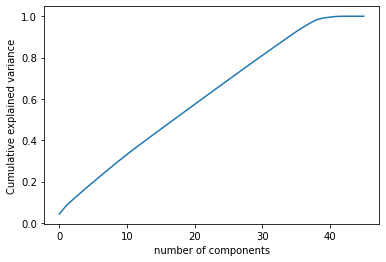

In [80]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [81]:
#Linear regressor for the raw data
regressor = LinearRegression() 
regressor.fit(X_train,y_train) 

#Linear regressor for the Feature selection group
regressor1 = LinearRegression() 
regressor1.fit(X_train_fs,y_train_fs) 

#Linear regressor for the Feature extraction group
regressor2 = LinearRegression() 
regressor2.fit(X_train_pca,y_train_pca) 

LinearRegression()

In [82]:
#Predict from the test features of raw data
y_pred = regressor.predict(X_test) 

#Predict from the test features of Feature Selection group
y_pred = regressor1.predict(X_test_fs) 

#Predict from the test features of Feature Extraction group
y_pred_pca = regressor2.predict(X_test_pca) 

In [83]:
#Evaluate the regressor on the raw data
print('RMSE score for the Multiple LR raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('Variance score for the Multiple LR raw is : %.2f' % regressor.score(X_test, y_test))
print("\n")

#Evaluate the regressor on the Feature selection group
print('RMSE score for the Multiple LR FS is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred))))
print('Variance score for the Multiple LR FS is : %.2f' % regressor1.score(X_test_fs, y_test_fs))
print("\n")

#Evaluate the regressor on the Feature extraction group
print('RMSE score for the Multiple LR PCA is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca,y_pred_pca))))
print('Variance score for the Multiple LR PCA is : %.2f' % regressor2.score(X_test_pca, y_test_pca))

RMSE score for the Multiple LR raw is : 2939.0288742852736
Variance score for the Multiple LR raw is : 0.06


RMSE score for the Multiple LR FS is : 2939.0288742852736
Variance score for the Multiple LR FS is : 0.06


RMSE score for the Multiple LR PCA is : 2939.028874285273
Variance score for the Multiple LR PCA is : 0.06
